In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
sns.set()

We'll be using the Complete Pokemon Dataset that can be found here:
https://www.kaggle.com/rounakbanik/pokemon/downloads/pokemon.zip/1

In [4]:
pokemon = pd.read_csv('pokemon.csv')
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
abilities            801 non-null object
against_bug          801 non-null float64
against_dark         801 non-null float64
against_dragon       801 non-null float64
against_electric     801 non-null float64
against_fairy        801 non-null float64
against_fight        801 non-null float64
against_fire         801 non-null float64
against_flying       801 non-null float64
against_ghost        801 non-null float64
against_grass        801 non-null float64
against_ground       801 non-null float64
against_ice          801 non-null float64
against_normal       801 non-null float64
against_poison       801 non-null float64
against_psychic      801 non-null float64
against_rock         801 non-null float64
against_steel        801 non-null float64
against_water        801 non-null float64
attack               801 non-null int64
base_egg_steps       801 non-null int64
base_happiness    

First we look at, in total, how many legendary and non-legendary pokemon there are.

In [5]:
pokemon['is_legendary'].value_counts()

0    731
1     70
Name: is_legendary, dtype: int64

So, the dataset is really imbalanced, as the legendary pokemon make up roughly 8 percent of the data set. Let's plot the relationship between height and weight for the pokemon, color coding which ones are legendary and not legendary. First we create a mapper function:

In [6]:
def computeLegendaryColor( isLegendary ):
    """
    Takes in whether or not pokemon is legendary and returns corresponding color
    
    Inputs:
    isLegendary - (int) zero or one if is legendary
    Outputs:
    col - (string) 'b' or 'r' if is legendary
    """
    if isLegendary:
        return 'r'
    else:
        return 'b'

In [7]:
pokemon['legendaryColor'] = pokemon['is_legendary'].apply(computeLegendaryColor)
pokemon['legendaryColor'].value_counts()

b    731
r     70
Name: legendaryColor, dtype: int64

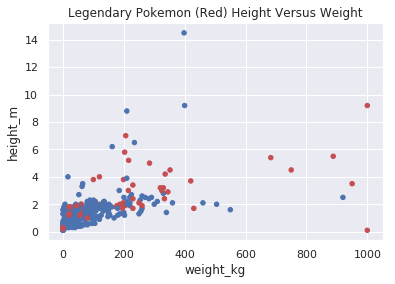

In [8]:
pokemon.plot(kind='scatter',x='weight_kg',y='height_m',c=pokemon['legendaryColor'],legend=True)
plt.title("Legendary Pokemon (Red) Height Versus Weight")
plt.show()

We see that legendary pokemon are the tallest or heaviest almonst exlusively, except for a few outliers of the non-legendary pokemon.


Now we will examine the proportion of legendary to non legendary pokemon by the type.
There are actually two fields for type. We could add their value counts together, because if two pokemon is a  member of a single type, where one is its first type and the other has that type as its second type, then technically there are two pokemon of that type. However, we must be careful because we will be overcounting the pokemon.

In [9]:
pokemon.groupby('type1')['is_legendary'].count()

type1
bug          72
dark         29
dragon       27
electric     39
fairy        18
fighting     28
fire         52
flying        3
ghost        27
grass        78
ground       32
ice          23
normal      105
poison       32
psychic      53
rock         45
steel        24
water       114
Name: is_legendary, dtype: int64

In [10]:
which_type = 'type1'
# divide the number of legendary pokemon in each type by the total number of pokemon in each type
proportion_legendary_by_type = pokemon.groupby(which_type)['is_legendary'].sum() / pokemon.groupby(which_type)['is_legendary'].count()

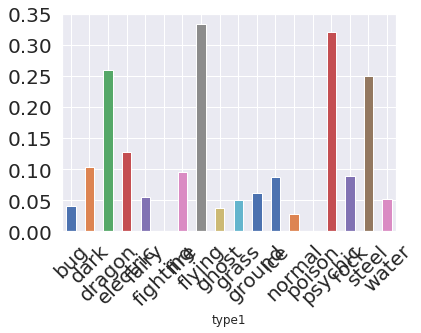

In [11]:
proportion_legendary_by_type.plot(kind='bar',rot=45,fontsize=20)
plt.show()

There are clear differences between the effect of the pokemon types in relation to their legendary status. We see that there are many flying, psychic and dragon legendary types, but there do not exist any poison or fighting legendary types (only considering the primary type of each pokemon)

Now lets do the same analysis, but looking at legendary status as a function of their fighter stats.

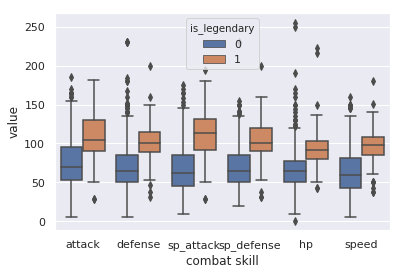

In [12]:
combat_stats = pokemon.loc[:,['attack','defense','sp_attack','sp_defense','hp','speed','is_legendary']]
melted_combat_stats = pd.melt(combat_stats, id_vars='is_legendary',var_name='combat skill')
sns.boxplot(x='combat skill',y='value',hue='is_legendary',data=melted_combat_stats)
plt.show()

As one might expect, the distribution of the combat skills for the legendary pokemon are all higher than their ordinary counterparts. The boxplot suggests a significant difference in all 6 variables. However, there are many outliers in every skill, implying that some legendary pokemon are anomalously weak, and that many ordinary pokemon tend to be very strong.

Now we'll start working on a classification tree

In [13]:
is_target = pokemon.columns == 'is_legendary'
predictors = ['attack','defense','sp_attack','sp_defense','hp','speed','height_m','weight_kg','type1']

y = pokemon.loc[:,is_target]
X = pokemon.loc[:,predictors]

x_train , x_test , y_train , y_test = train_test_split( X, y, test_size=0.2, random_state=42 )
print(x_train.shape)

x_train = pd.DataFrame(x_train, columns=predictors)
x_test = pd.DataFrame(x_test, columns=predictors)

(640, 9)


We don't need to perform any sort of normalization because decision trees (therefore random forests) are scale agnostic. However, the ```type1``` predictor is a categorical variable, so we should use a one-hot encoding to turn that single column into a set of binary columns

In [14]:
x_train[predictors].isna().any()

attack        False
defense       False
sp_attack     False
sp_defense    False
hp            False
speed         False
height_m       True
weight_kg      True
type1         False
dtype: bool

We see that we have some NaNs inside height and weight for the pokemon. Let's impute those NaNs with the average value

In [15]:
imputer = SimpleImputer()
impute_cols = ['weight_kg','height_m']

x_train_weight_height_imputed = pd.DataFrame(imputer.fit_transform( x_train[impute_cols] ), columns=impute_cols,
                                            index=x_train.index)
x_test_weight_height_imputed = pd.DataFrame(imputer.transform( x_test[impute_cols] ), columns=impute_cols,
                                           index=x_test.index)

x_train.drop(['weight_kg','height_m'],inplace=True,axis=1)
x_test.drop(['weight_kg','height_m'],inplace=True,axis=1)

In [16]:
one_hot_encoder = OneHotEncoder()

one_hot_training_types = one_hot_encoder.fit_transform(x_train[['type1']]).toarray()
one_hot_test_types = one_hot_encoder.transform(x_test[['type1']]).toarray()


one_hot_training_types = pd.DataFrame(one_hot_training_types,columns=one_hot_encoder.categories_,
                                     index=x_train.index)
one_hot_test_types = pd.DataFrame(one_hot_test_types,columns=one_hot_encoder.categories_,
                                 index=x_test.index)

one_hot_imputed_x_train = pd.concat([x_train,x_train_weight_height_imputed,one_hot_training_types],axis=1,join='inner').drop('type1',axis=1)
one_hot_imputed_x_test = pd.concat([x_test,x_test_weight_height_imputed,one_hot_test_types],axis=1,join='inner').drop('type1',axis=1)

Now we fit a decision tree and a random forest. The classification decision tree serves as a baseline model against which we can compare the random forest. 

In [17]:
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=100, oob_score=True)

decision_tree.fit(one_hot_imputed_x_train,y_train)
random_forest.fit(one_hot_imputed_x_train,y_train)

decision_tree_predictions = decision_tree.predict( one_hot_imputed_x_test )
random_forest_predictions = random_forest.predict( one_hot_imputed_x_test )

decision_tree_accuracy = accuracy_score( y_test , decision_tree_predictions )
random_forest_accuracy = accuracy_score( y_test , random_forest_predictions )
decision_tree_f1_score = accuracy_score( y_test , decision_tree_predictions )
random_forest_f1_score = accuracy_score( y_test , random_forest_predictions )

print("Decision Tree Accuracy: {}".format(decision_tree_accuracy))
print("Decision Tree F1 Score: {}".format(decision_tree_accuracy))
print("Random Forest Accuracy: {}".format(random_forest_accuracy))
print("Random Forest F1 Score: {}".format(random_forest_accuracy))

Decision Tree Accuracy: 0.906832298136646
Decision Tree F1 Score: 0.906832298136646
Random Forest Accuracy: 0.9130434782608695
Random Forest F1 Score: 0.9130434782608695


/home/joseph/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [18]:
print("Score of training dataset using out-of-bag estimate: {}".format(random_forest.oob_score_))

Score of training dataset using out-of-bag estimate: 0.9453125


In [20]:
feature_importances =  pd.DataFrame(random_forest.feature_importances_,
                                   index=one_hot_imputed_x_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
speed,0.151565
height_m,0.119869
sp_defense,0.118972
hp,0.118754
sp_attack,0.115406
weight_kg,0.108515
defense,0.081686
attack,0.078340
"(psychic,)",0.035128
"(steel,)",0.010791
